In [30]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix

import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.util import ngrams
nltk.download('stopwords')

import scipy.sparse
from wordcloud import WordCloud
import re
import string
from pprint import pprint
from textblob import TextBlob
import spacy

from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim import matutils, models

#tomotopy
import tomotopy as tp

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yutongwang/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Import Data

In [3]:
data = pd.read_excel("data.xlsx", names = ['Professor id', 'First Name', 'Last Name', 'University',
                                              'Department', 'Course', 'Quality', 'Difficulty', 'Comments'])
data = data.dropna()
data = data.drop_duplicates();
data['Comments'] = data['Comments'].astype(str)
data = data[data['Comments'] != 'No Comments']
#data.head()

/Users/yutongwang/opt/anaconda3/lib/python3.8/site-packages/xlrd/xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
/Users/yutongwang/opt/anaconda3/lib/python3.8/site-packages/xlrd/xlsx.py:312: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
/Users/yutongwang/opt/anaconda3/lib/python3.8/site-packages/xlrd/xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


In [4]:
# data['University'].unique()

In [5]:
#top 25 schools
data_top25 = data[data['University'].isin(['Harvard University', 'Yale University', 
                                           'Brown University', 'Columbia University', 
                                           'Massachusetts Institute of Technology', 
                                           'Princeton University', 'Stanford University', 
                                           'University of Chicago', 'University of Pennsylvania', 
                                          'California Institute of Technology', 'Johns Hopkins University',
                                          'Duke University', 'Dartmouth College', 'Vanderbilt University',
                                          'Rice University', 'Washington University in St. Louis', 'Cornell University',
                                          'University of Notre Dame', 'University of California Los Angeles (UCLA)',
                                          'Emory University', 'University of California Berkeley', 
                                          'Georgetown University', 'University of Michigan', 'University of Southern California'])]
#data_top25.head()

In [6]:
#100~125 schools
data_low25 = pd.read_excel("data_lowerrank.xlsx", names = ['Professor id', 'First Name', 'Last Name', 'University',
                                              'Department', 'Course', 'Quality', 'Difficulty', 'Comments'])
data_low25 = data_low25.dropna()
data_low25 = data_low25.drop_duplicates();
data_low25['Comments'] = data_low25['Comments'].astype(str)
data_low25 = data_low25[data_low25['Comments'] != 'No Comments']

/Users/yutongwang/opt/anaconda3/lib/python3.8/site-packages/xlrd/xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
/Users/yutongwang/opt/anaconda3/lib/python3.8/site-packages/xlrd/xlsx.py:312: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
/Users/yutongwang/opt/anaconda3/lib/python3.8/site-packages/xlrd/xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


In [7]:
data_low25_highQ = data_low25[data_low25['Quality'].isin([5.0, 4.5, 4.0, 3.5])]
data_low25_lowQ = data_low25[data_low25['Quality'].isin([3.0, 2.5, 2.0, 1.5, 1.0])]

In [8]:
#Ivy League Schools
data_ivy = data[data['University'].isin(['Harvard University', 'Yale University', 
                                         'Brown University', 'Columbia University', 
                                         'Princeton University', 'University of Pennsylvania', 
                                         'Dartmouth College', 'Cornell University'])]

In [9]:
data_ivy_highQ = data_ivy[data_ivy['Quality'].isin([5.0, 4.5])]
data_ivy_lowQ = data_ivy[data_ivy['Quality'].isin([1.5, 1.0])]
data_ivy_mid = data_ivy[data_ivy['Quality'].isin([4.0, 3.5, 3.0, 2.5, 2.0])]

In [10]:
#Big Ten Schoo
data_BigTen = data[data['University'].isin(['Michigan State University', 'Pennsylvania State University',
                                            'Purdue University - West Lafayette', 'Rutgers - State University of New Jersey',
                                            'The Ohio State University', 'Indiana University Bloomington',
                                            'University Of Illinois at Urbana - Champaign',
                                            'University of Iowa', 'University of Maryland',
                                            'University of Michigan', 'University of Minnesota - Twin Cities',
                                            'University of Nebraska-Lincoln', 'University of Wisconsin - Madison'])]

In [11]:
data_BigTen_highQ = data_BigTen[data_BigTen['Quality'].isin([5.0, 4.5])]
data_BigTen_lowQ = data_BigTen[data_BigTen['Quality'].isin([1.5, 1.0])]
data_BigTen_mid = data_BigTen[data_BigTen['Quality'].isin([4.0, 3.5, 3.0, 2.5, 2.0])]

In [12]:
#Community Colleges
data_com = pd.read_excel("data_community.xlsx", names = ['Professor id', 'First Name', 'Last Name', 'University',
                                              'Department', 'Course', 'Quality', 'Difficulty', 'Comments'])
data_com = data_com.dropna()
data_com = data_com.drop_duplicates();
data_com['Comments'] = data_com['Comments'].astype(str)
data_com = data_com[data_com['Comments'] != 'No Comments']

/Users/yutongwang/opt/anaconda3/lib/python3.8/site-packages/xlrd/xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
/Users/yutongwang/opt/anaconda3/lib/python3.8/site-packages/xlrd/xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


In [13]:
data_com_highQ = data_com[data_com['Quality'].isin([5.0, 4.5])]
data_com_lowQ = data_com[data_com['Quality'].isin([1.5, 1.0])]
data_com_mid = data_com[data_com['Quality'].isin([4.0, 3.5, 3.0, 2.5, 2.0])]

In [14]:
data_prof_avg_rate = pd.read_csv("data_prof_avg.csv", names = ['Professor id', 'OverallRatings', 'First Name', 'Last Name', 'University',
                                              'Department', 'Course', 'Quality', 'Difficulty', 'Comments'])

# EDA

In [ ]:
#References
'''Some function credit to 
https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove
https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial
https://www.kaggle.com/itratrahman/nlp-tutorial-using-python
https://www.kaggle.com/marcovasquez/basic-nlp-with-tensorflow-and-wordcloud
https://www.kaggle.com/akensert/bert-base-tf2-0-minimalistic
https://www.kaggle.com/khoongweihao/bert-base-tf2-0-minimalistic-iii
https://www.kaggle.com/vbmokin/disaster-nlp-keras-bert-using-tfhub-tuning
https://www.kaggle.com/user123454321/bert-starter-inference
https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub
https://www.kaggle.com/wrrosa/keras-bert-using-tfhub-modified-train-data
https://www.kaggle.com/rftexas/text-only-kfold-bert
https://github.com/hundredblocks/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb
https://tfhub.dev/s?q=bert'''

In [17]:
df = data
dfl = data_low25
df = df.dropna()
dfl = dfl.dropna(axis=0)

In [18]:
def length(text):    
    '''a function which returns the length of text'''
    return len(str(text))
def words(text):
    '''a function which returns the number of words in the text'''
    if type(text) == float:
        pass
    else:
        return len(text.split())

In [20]:
df['length'] = df['Comments'].apply(length)
df['words'] = df['Comments'].apply(words)
dfl['length'] = dfl['Comments'].apply(length)
dfl['words'] = dfl['Comments'].apply(words)

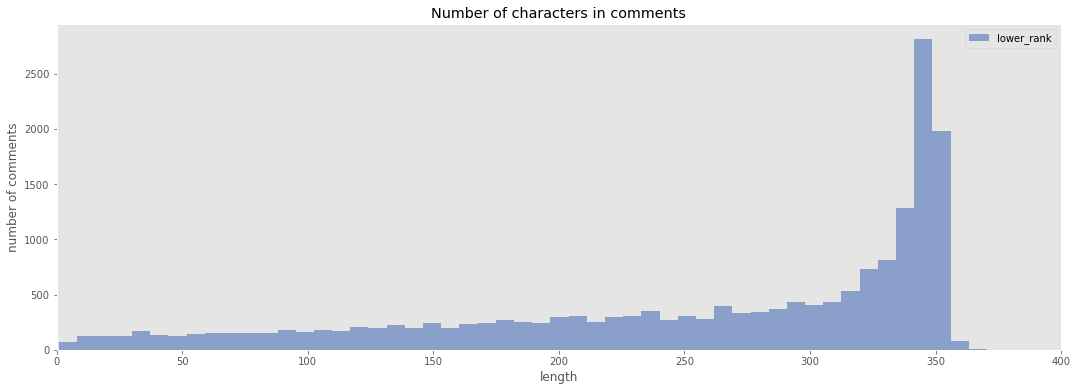

In [21]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 200
#plt.hist(df['length'], alpha = 0.6, bins=bins, label='top_rank', color='#DE3F24')
plt.hist(dfl['length'], alpha = 0.8, bins=bins, label='lower_rank', color='#748EC4')
plt.xlabel('length')
plt.ylabel('number of comments')
plt.title('Number of characters in comments')
plt.legend(loc='upper right')
plt.xlim(0,400)
plt.grid()
plt.show()

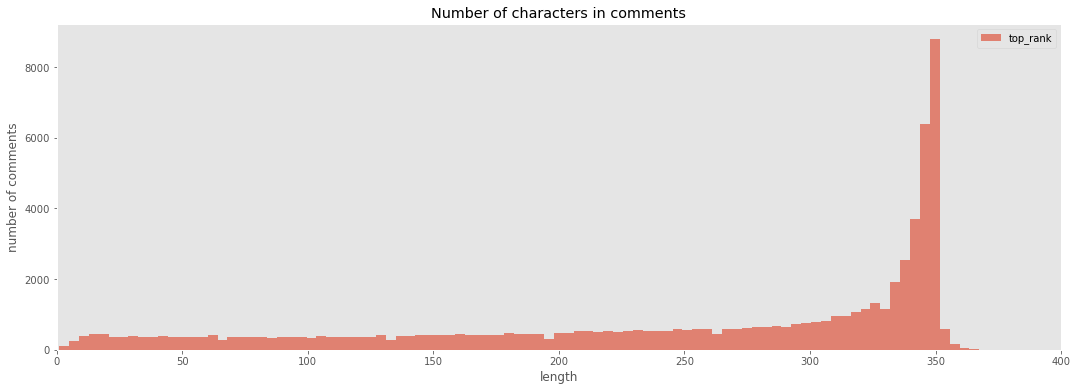

In [22]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 200
plt.hist(df['length'], alpha = 0.6, bins=bins, label='top_rank', color='#DE3F24')
#plt.hist(dfl['length'], alpha = 0.8, bins=bins, label='lower_rank', color='#748EC4')
plt.xlabel('length')
plt.ylabel('number of comments')
plt.title('Number of characters in comments')
plt.legend(loc='upper right')
plt.xlim(0,400)
plt.grid()
plt.show()

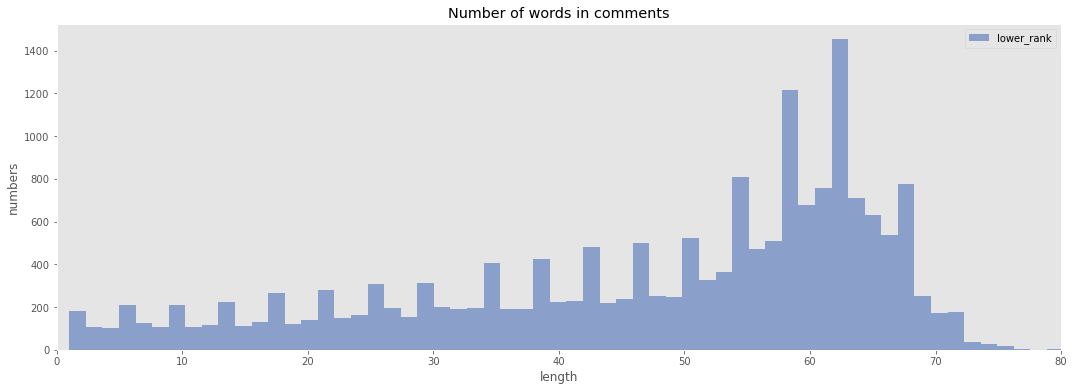

In [23]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 200
#plt.hist(df['words'], alpha = 0.6, bins=bins, label='top_rank', color='#DE3F24')
plt.hist(dfl['words'], alpha = 0.8, bins=bins, label='lower_rank', color='#748EC4')
plt.xlabel('length')
plt.ylabel('numbers')
plt.title('Number of words in comments')
plt.legend(loc='upper right')
plt.xlim(0,80)
plt.grid()
plt.show()

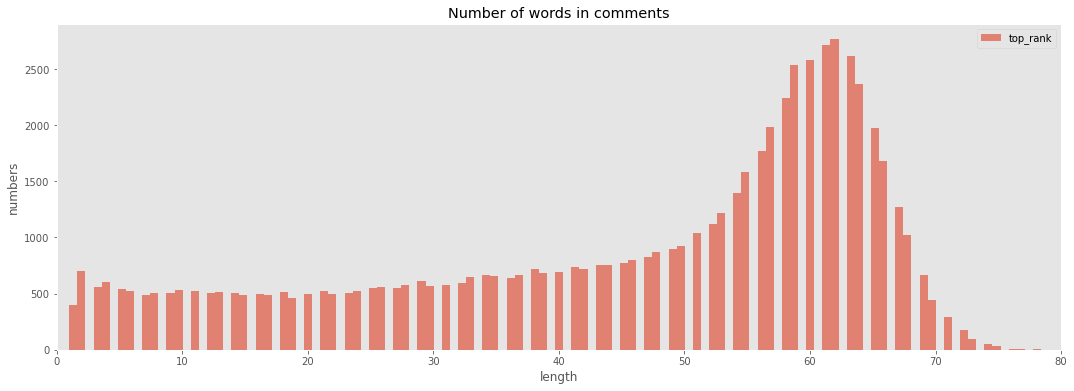

In [24]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 200
plt.hist(df['words'], alpha = 0.6, bins=bins, label='top_rank', color='#DE3F24')
#plt.hist(dfl['words'], alpha = 0.8, bins=bins, label='lower_rank', color='#748EC4')
plt.xlabel('length')
plt.ylabel('numbers')
plt.title('Number of words in comments')
plt.legend(loc='upper right')
plt.xlim(0,80)
plt.grid()
plt.show()

## Analyze Stop Words

In [25]:
def create_corpus(df):
    '''a function that create a list of words from the comments
    '''
    corpus = []
    text = df['Comments'].tolist()
    for i in range(len(text)):
        if type(text[i]) == str:
            for j in text[i].split():
                corpus.append(j)
        else: 
            text[i] = str(text[i])
            for j in text[i].split():
                corpus.append(j)
    return corpus

In [26]:
corpus_low = create_corpus(dfl)
corpus_top = create_corpus(df)

In [31]:
stop=set(stopwords.words('english'))
def GenerateTopStopWrods(corpus):
    '''a function that find top 10 most frequent stop words
    '''
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
    return top

In [32]:
top = GenerateTopStopWrods(corpus_top)
top_low = GenerateTopStopWrods(corpus_low)

<BarContainer object of 10 artists>

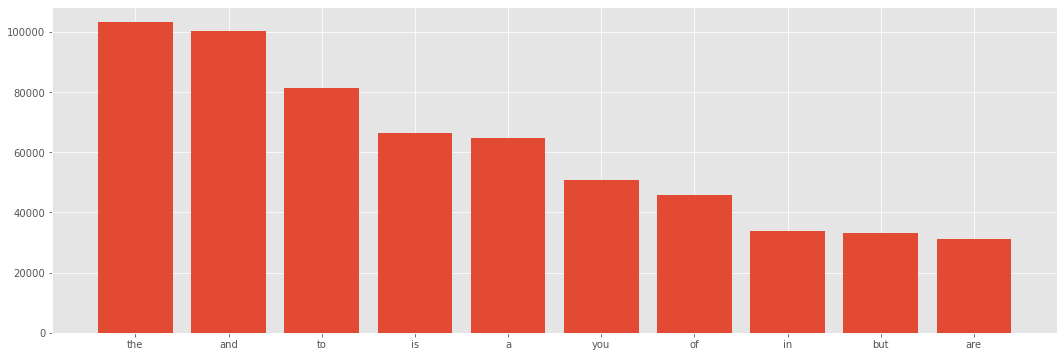

In [33]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 10 artists>

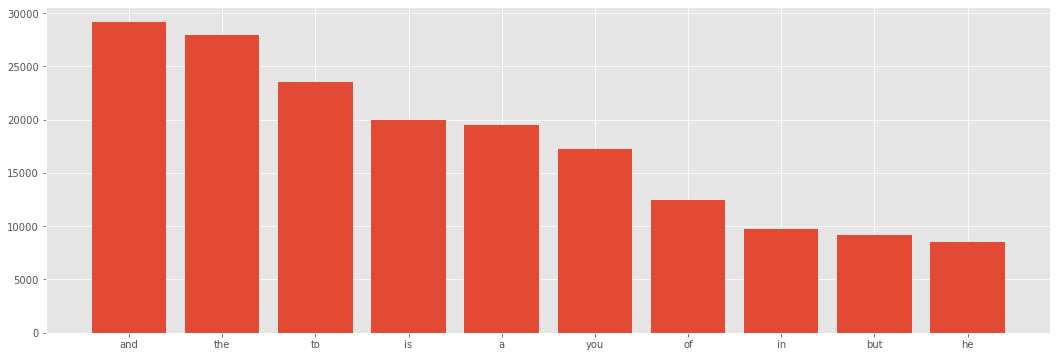

In [34]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top_low)
plt.bar(x,y)

## Analyze Punctuations

In [35]:
def GenerateTopPunc(corpus):
    '''a function that find top 10 most frequent stop words
    '''
    dic=defaultdict(int)
    special = string.punctuation
    for i in corpus:
        if i in special:
            dic[i]+=1
    dic = {k: v for k, v in sorted(dic.items(), key=lambda item: item[1], reverse=True)}
    return dic

In [36]:
punc_top = GenerateTopPunc(corpus_top)
punc_low = GenerateTopPunc(corpus_low)

<BarContainer object of 22 artists>

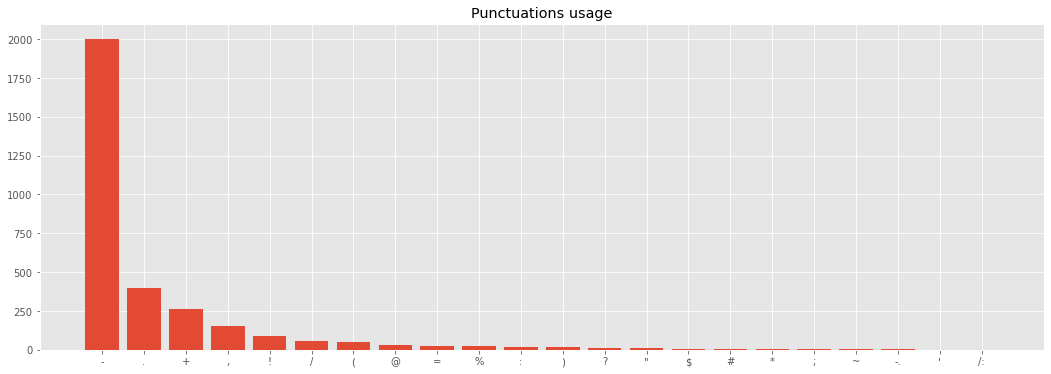

In [37]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.title("Punctuations usage")
x,y=zip(*punc_top.items())
plt.bar(x,y)

<BarContainer object of 16 artists>

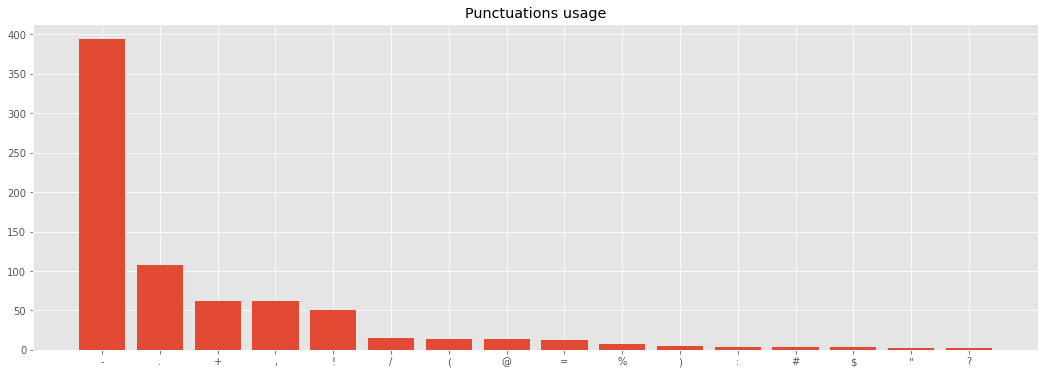

In [38]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.title("Punctuations usage")
x,y=zip(*punc_low.items())
plt.bar(x,y)

In [39]:
def get_top_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [40]:
top_bigrams=get_top_bigrams(df['Comments'])[:10]

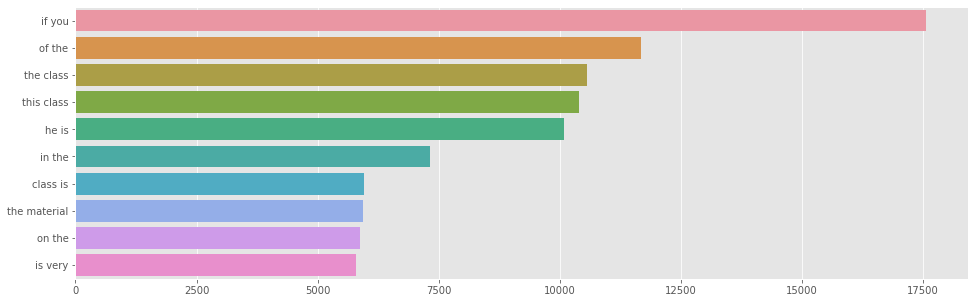

In [41]:
plt.figure(figsize=(16,5))
x,y=map(list,zip(*top_bigrams))
sns.barplot(x=y,y=x)

## Sentiment Analysis

In [42]:
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

<ipython-input-45-b1db9f87da50>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ivy_highQ['polarity'] = data_ivy_highQ['Comments'].apply(pol)
<ipython-input-45-b1db9f87da50>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ivy_highQ['subjectivity'] = data_ivy_highQ['Comments'].apply(sub)


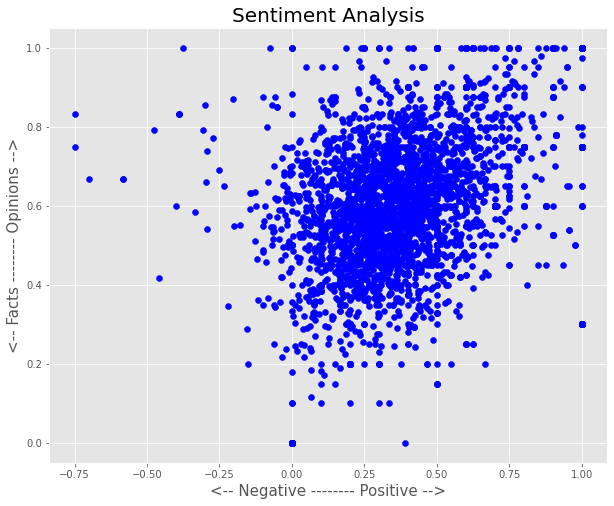

In [45]:
data_ivy_highQ['polarity'] = data_ivy_highQ['Comments'].apply(pol)
data_ivy_highQ['subjectivity'] = data_ivy_highQ['Comments'].apply(sub)

plt.rcParams['figure.figsize'] = [10, 8]

x = data_ivy_highQ.polarity
y = data_ivy_highQ.subjectivity
plt.scatter(x, y, color='blue')
    
plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)

plt.show()

<ipython-input-46-645e7080fc2a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ivy_lowQ['polarity'] = data_ivy_lowQ['Comments'].apply(pol)
<ipython-input-46-645e7080fc2a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ivy_lowQ['subjectivity'] = data_ivy_lowQ['Comments'].apply(sub)


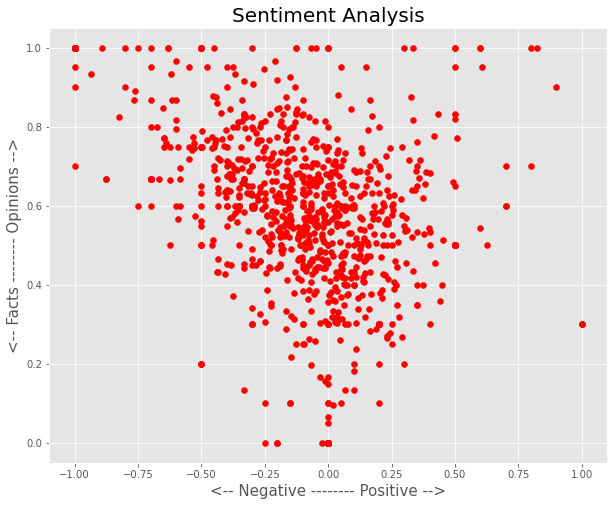

In [46]:
data_ivy_lowQ['polarity'] = data_ivy_lowQ['Comments'].apply(pol)
data_ivy_lowQ['subjectivity'] = data_ivy_lowQ['Comments'].apply(sub)

plt.rcParams['figure.figsize'] = [10, 8]

x = data_ivy_lowQ.polarity
y = data_ivy_lowQ.subjectivity
plt.scatter(x, y, color='red')
    
plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)

plt.show()

<ipython-input-47-27cd5d034c70>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_low25_highQ['polarity'] = data_low25_highQ['Comments'].apply(pol)
<ipython-input-47-27cd5d034c70>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_low25_highQ['subjectivity'] = data_low25_highQ['Comments'].apply(sub)


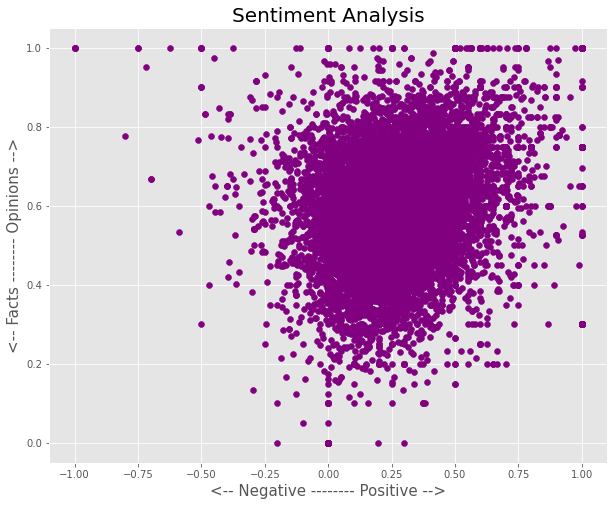

In [47]:
data_low25_highQ['polarity'] = data_low25_highQ['Comments'].apply(pol)
data_low25_highQ['subjectivity'] = data_low25_highQ['Comments'].apply(sub)

plt.rcParams['figure.figsize'] = [10, 8]

x = data_low25_highQ.polarity
y = data_low25_highQ.subjectivity
plt.scatter(x, y, color='purple')
    
plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)

plt.show()

<ipython-input-48-baf396b5a803>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_low25_lowQ['polarity'] = data_low25_lowQ['Comments'].apply(pol)
<ipython-input-48-baf396b5a803>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_low25_lowQ['subjectivity'] = data_low25_lowQ['Comments'].apply(sub)


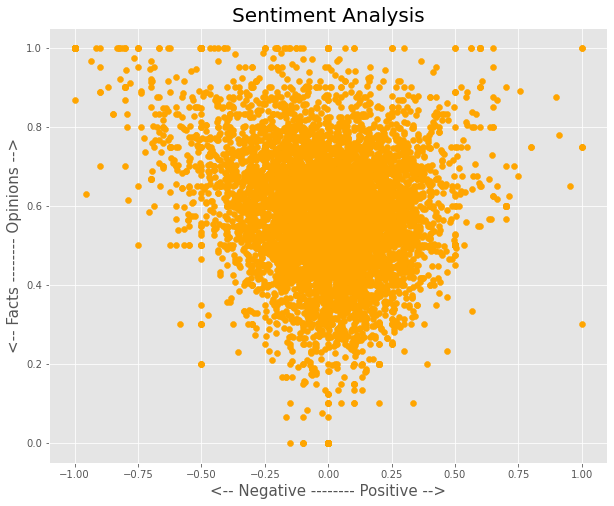

In [48]:
data_low25_lowQ['polarity'] = data_low25_lowQ['Comments'].apply(pol)
data_low25_lowQ['subjectivity'] = data_low25_lowQ['Comments'].apply(sub)

plt.rcParams['figure.figsize'] = [10, 8]

x = data_low25_lowQ.polarity
y = data_low25_lowQ.subjectivity
plt.scatter(x, y, color='orange')
    
plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)

plt.show()

In [49]:
#data_top25_lowQ[data_top25_lowQ['polarity'] == 1]
#data_top25_highQ[data_top25_highQ['polarity'] == -1]
#data_top25_lowQ[data_top25_lowQ['subjectivity'] == 0]
#data_top25_highQ[data_top25_highQ['subjectivity'] == 0]

In [50]:
# data_low25_lowQ[data_low25_lowQ['polarity'] == 1]
# data_low25_highQ[data_low25_highQ['polarity'] == -1]
# data_low25_lowQ[data_low25_lowQ['subjectivity'] == 0]
# data_low25_highQ[data_low25_highQ['subjectivity'] == 0]

## Pie Charts

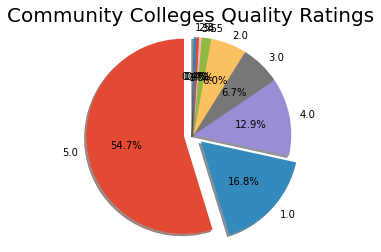

In [51]:
n = sum(list(data_com.Quality.value_counts()))
sizes_list = []
for i in list(data_com.Quality.value_counts()):
    sizes_list.append(i/n)
labels = list(data_com.Quality.value_counts().index)
explode = (0.1, 0.1, 0, 0, 0, 0, 0, 0, 0)

fig1, ax1 = plt.subplots(figsize = (6,4))
ax1.pie(sizes_list, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Community Colleges Quality Ratings", fontsize = 20)
plt.show()
        

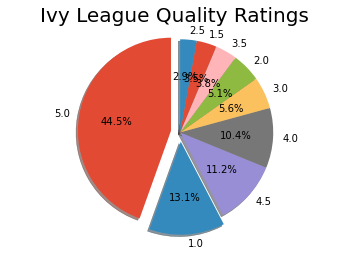

In [52]:
n = sum(list(data_ivy.Quality.value_counts()))
sizes_list = []
for i in list(data_ivy.Quality.value_counts()):
    sizes_list.append(i/n)
labels = list(data_ivy.Quality.value_counts().index)
explode = (0.1, 0.1, 0, 0, 0, 0, 0, 0, 0)

fig1, ax1 = plt.subplots(figsize = (6,4))
ax1.pie(sizes_list, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Ivy League Quality Ratings", fontsize = 20)
plt.show()

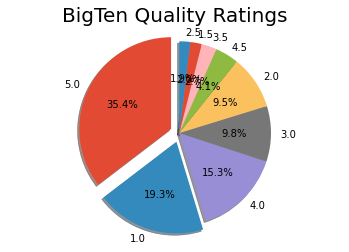

In [53]:
n = sum(list(data_BigTen.Quality.value_counts()))
sizes_list = []
for i in list(data_BigTen.Quality.value_counts()):
    sizes_list.append(i/n)
labels = list(data_BigTen.Quality.value_counts().index)
explode = (0.1, 0.1, 0, 0, 0, 0, 0, 0, 0)

fig1, ax1 = plt.subplots(figsize = (6,4))
ax1.pie(sizes_list, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("BigTen Quality Ratings", fontsize = 20)
plt.show()

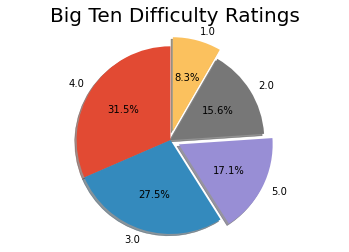

In [54]:
n = sum(list(data_BigTen.Difficulty.value_counts()))
sizes_list = []
for i in list(data_BigTen.Difficulty.value_counts()):
    sizes_list.append(i/n)
labels = list(data_BigTen.Difficulty.value_counts().index)
explode = (0,0,0.1,0,0.1)

fig1, ax1 = plt.subplots(figsize = (6,4))
ax1.pie(sizes_list, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Big Ten Difficulty Ratings", fontsize = 20)
plt.show()

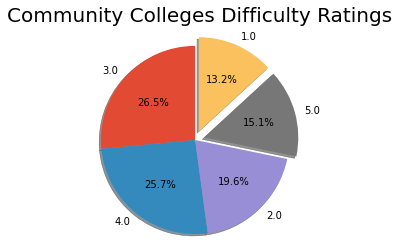

In [61]:
n = sum(list(data_com.Difficulty.value_counts()))
sizes_list = []
for i in list(data_com.Difficulty.value_counts()):
    sizes_list.append(i/n)
labels = list(data_com.Difficulty.value_counts().index)
explode = (0,0,0,0.1,0.1)

fig1, ax1 = plt.subplots(figsize = (6,4))
ax1.pie(sizes_list, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Community Colleges Difficulty Ratings", fontsize = 20)
plt.show()

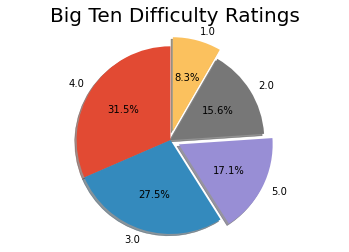

In [56]:
n = sum(list(data_BigTen.Difficulty.value_counts()))
sizes_list = []
for i in list(data_BigTen.Difficulty.value_counts()):
    sizes_list.append(i/n)
labels = list(data_BigTen.Difficulty.value_counts().index)
explode = (0,0,0.1,0,0.1)

fig1, ax1 = plt.subplots(figsize = (6,4))
ax1.pie(sizes_list, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Big Ten Difficulty Ratings", fontsize = 20)
plt.show()

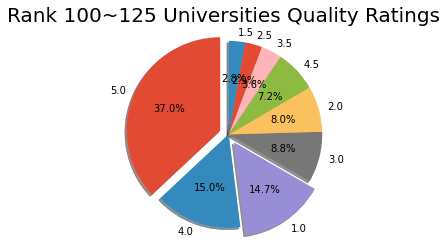

In [62]:
n = sum(list(data_low25.Quality.value_counts()))
sizes_list = []
for i in list(data_low25.Quality.value_counts()):
    sizes_list.append(i/n)
labels = '5.0', '4.0', '1.0', '3.0', '2.0', '4.5', '3.5', '2.5', '1.5'
explode = (0.1, 0, 0.1, 0, 0, 0, 0, 0, 0)

fig1, ax1 = plt.subplots(figsize = (6,4))
ax1.pie(sizes_list, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
ax1.set_title("Rank 100~125 Universities Quality Ratings", fontsize = 20)

plt.show()

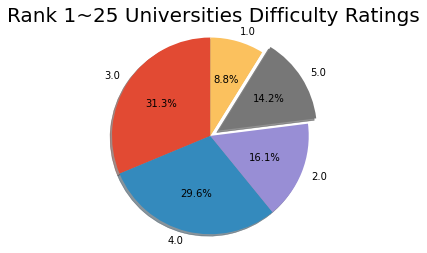

In [63]:
n = sum(list(data_top25.Difficulty.value_counts()))
sizes_list = []
for i in list(data_top25.Difficulty.value_counts()):
    sizes_list.append(i/n)
labels = '3.0', '4.0', '2.0', '5.0', '1.0'
explode = (0, 0, 0, 0.1, 0)

fig1, ax1 = plt.subplots(figsize = (6,4))
ax1.pie(sizes_list, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
ax1.set_title("Rank 1~25 Universities Difficulty Ratings", fontsize = 20)

plt.show()

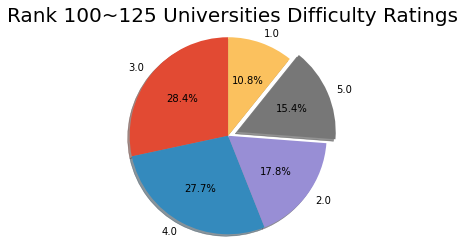

In [64]:
n = sum(list(data_low25.Difficulty.value_counts()))
sizes_list = []
for i in list(data_low25.Difficulty.value_counts()):
    sizes_list.append(i/n)
labels = '3.0', '4.0', '2.0', '5.0', '1.0'
explode = (0, 0, 0, 0.1, 0)

fig1, ax1 = plt.subplots(figsize = (6,4))
ax1.pie(sizes_list, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
ax1.set_title("Rank 100~125 Universities Difficulty Ratings", fontsize = 20)

plt.show()

## Correlation

In [65]:
def Ratecorrelation(data):
    correlation = data['Quality'].corr(data['Difficulty'])
    return correlation

In [67]:
print(Ratecorrelation(data_ivy))
print(Ratecorrelation(data_com))
print(Ratecorrelation(data_BigTen))
print(Ratecorrelation(data_top25))

-0.17836894419618105
-0.5153400063148065
-0.42448888782244837
-0.26242225058893937


# LDA

In [ ]:
#References
'''Some functions credit to:
   https://github.com/adashofdata/nlp-in-python-tutorial
   https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
   https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
   '''

## Traditional LDA

In [60]:
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

round1 = lambda x: clean_text_round1(x)

<>:4: DeprecationWarning: invalid escape sequence \[
<>:6: DeprecationWarning: invalid escape sequence \w
<>:4: DeprecationWarning: invalid escape sequence \[
<>:6: DeprecationWarning: invalid escape sequence \w
<ipython-input-60-e7ad0f82f338>:4: DeprecationWarning: invalid escape sequence \[
  text = re.sub('\[.*?\]', '', text)
<ipython-input-60-e7ad0f82f338>:6: DeprecationWarning: invalid escape sequence \w
  text = re.sub('\w*\d\w*', '', text)


In [15]:
def clean_text_round2(text):
    '''Get rid of some additional punctuation and non-sensical text that was missed the first time around.'''
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

round2 = lambda x: clean_text_round2(x)

In [ ]:
# def TopicModeling(data, stop_words, num_topics):
#     data_clean = pd.DataFrame(data.Comments.apply(round1))
#     data_clean = pd.DataFrame(data_clean.Comments.apply(round2))
#     cv = CountVectorizer(stop_words=stop_words)
#     data_cv = cv.fit_transform(data_clean.Comments)
#     data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
#     data_tdm = data_dtm.transpose()
#     sparse_counts = scipy.sparse.csr_matrix(data_tdm)
#     corpus = matutils.Sparse2Corpus(sparse_counts)
#     id2word = dict((v, k) for k, v in cv.vocabulary_.items())
#     lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics= num_topics, passes=10)
#     return lda.print_topics()

In [16]:
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [17]:
def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [18]:
def adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [53]:
def TopicModeling(data, stop_words, num_topics):
    data_clean = pd.DataFrame(data.Comments.apply(round1))
    data_clean = pd.DataFrame(data_clean.Comments.apply(round2))
    cv = CountVectorizer(stop_words=stop_words)
    data_nouns_adj = pd.DataFrame(data_clean.Comments.apply(nouns_adj))
    data_cv = cv.fit_transform(data_nouns_adj.Comments)
    data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
    data_tdm = data_dtm.transpose()
    sparse_counts = scipy.sparse.csr_matrix(data_tdm)
    corpus = matutils.Sparse2Corpus(sparse_counts)
    id2word = dict((v, k) for k, v in cv.vocabulary_.items())
    lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics= num_topics, passes=10)
    coherence_model_lda = CoherenceModel(model=lda, texts=corpus, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

In [50]:
add_stop_words = ['like', 'im', 'know', 'just', 'dont', 'thats', 'right', 'people',
                  'youre', 'got', 'gonna', 'time', 'think', 'yeah', 'said', 'class',
                  'students', 'really', 'professor', 'lectures', 'course', 've',
                  'teacher', 'prof', 'lecture', 'professors', 'classes', 'ive', 'hes', 'shes', 'dr',
                  'man', 'subject', 'lot', 'guy', 'lecturer', 'way', 'history', 'chemistry', 'physics', 'math',
                  'school', 'years', 'student', 'material', 'doesnt', 'doesn', 'amp']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

In [ ]:
for i in range(2,5):
    print(TopicModeling(data_top25_lowQ, stop_words, num_topics = i))

In [20]:
def create_corpus(data):
    corpus=[]
    data_clean = pd.DataFrame(data.Comments.apply(round1))
    data_clean = pd.DataFrame(data_clean.Comments.apply(round2))
    data_nouns_adj = pd.DataFrame(data_clean.Comments.apply(nouns_adj))
    for x in data_nouns_adj['Comments'].str.split():
        for i in x:
            if i not in list(stop_words):
                corpus.append(i)
    return corpus

In [21]:
def create_wordcloud(corpus):
    plt.figure(figsize=(12,8))
    word_cloud = WordCloud(
                              background_color='white',
                              max_font_size = 80
                             ).generate(" ".join(corpus[:]))
    plt.imshow(word_cloud)
    plt.axis('off')
    
    return plt.show()

In [ ]:
# corpus = create_corpus(data_top25)
# create_wordcloud(corpus)

## BiGram & TriGram LDA

In [23]:
def sent_to_words(data):
    for sentence in data:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data_BigTen['Comments']))


In [24]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=20) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=20)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


In [25]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [40]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

data_words_trigrams = make_trigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ'])

#print(data_lemmatized)

In [41]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]]


In [42]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('background', 1),
  ('caring', 1),
  ('intensive', 1),
  ('interesting', 1),
  ('kind', 1),
  ('knowledgable', 1),
  ('meet', 1),
  ('talk', 1),
  ('truly_want', 1),
  ('willing', 1)]]

In [61]:
Colist = []
for i in range(5,6):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=i,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)
    #pprint(lda_model.print_topics())
    print('\nPerplexity: ', i, lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', i, coherence_lda)
    Colist.append([lda_model.log_perplexity(corpus), coherence_lda, i])


Perplexity:  5 -6.974439868726347

Coherence Score:  5 0.24212929016167078


In [44]:
Colist

[[-6.974439855183101, 0.24212929016167078, 5],
 [-7.018048315520359, 0.24893937826883375, 6],
 [-7.065046384608395, 0.28082224987048715, 7],
 [-7.136431692739473, 0.2532362987279085, 8],
 [-7.223562206362441, 0.27093045104798547, 9],
 [-7.353951128709855, 0.2574946892206439, 10],
 [-7.556702995479118, 0.23868376367995692, 11],
 [-7.9397647247013055, 0.28204429681633275, 12],
 [-8.567868013758424, 0.27853148150030943, 13],
 [-9.619227259761786, 0.27190683690033757, 14],
 [-10.819410725821939, 0.2912368421441544, 15],
 [-12.194300193037918, 0.29272552725619005, 16],
 [-13.480900181850862, 0.2890063046020895, 17],
 [-14.03581105283162, 0.3020556504074887, 18],
 [-14.392460657966172, 0.2952160448852489, 19],
 [-14.831278780923581, 0.33495601244757, 20],
 [-15.198815744634228, 0.2841544540196918, 21],
 [-15.576849461145096, 0.2724160907770283, 22],
 [-15.951813171250285, 0.3057194567689909, 23],
 [-16.34751087728662, 0.2866625330772461, 24],
 [-16.775260594705014, 0.2772384477207325, 25],
 

In [37]:
TriCo = pd.DataFrame(Colist)

In [45]:
BiCo = pd.DataFrame(Colist)

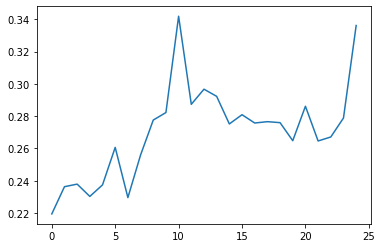

In [38]:
plt.plot(TriCo[1])

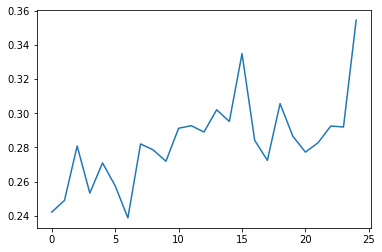

In [46]:
plt.plot(BiCo[1])

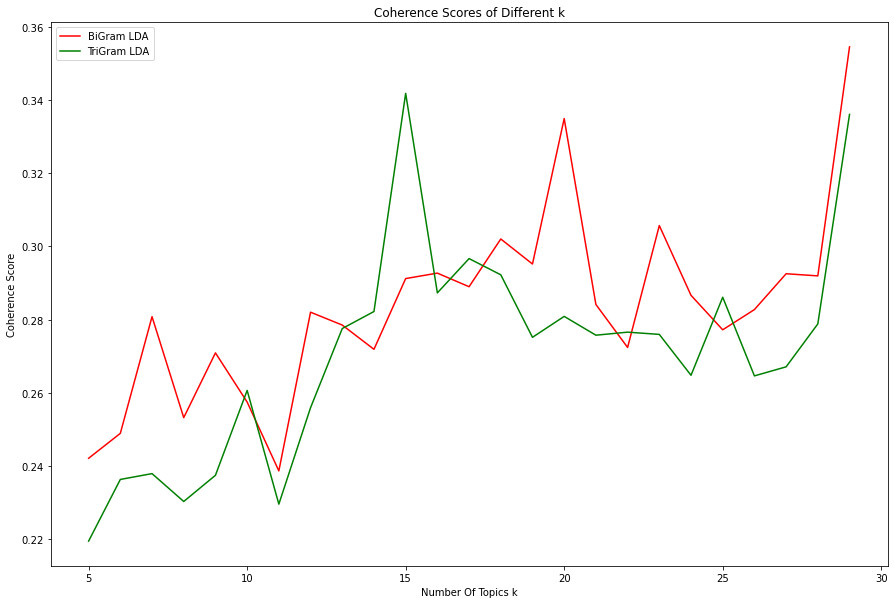

In [60]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(BiCo[2], BiCo[1], label = 'BiGram LDA', color = 'red')
ax.plot(TriCo[2], TriCo[1], label = 'TriGram LDA', color= 'green')
ax.set_xlabel('Number Of Topics k')
ax.set_ylabel('Coherence Score')
ax.set_title("Coherence Scores of Different k")
ax.legend()
plt.show()

In [62]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.400457  0.051732       1        1  30.117229
3      0.155709  0.360598       2        1  22.814890
2      0.089951 -0.164149       3        1  18.258339
4      0.091187 -0.176944       4        1  17.829870
1      0.063610 -0.071237       5        1  10.979681, topic_info=          Term         Freq        Total Category  logprob  loglift
11        exam  6227.000000  6227.000000  Default  30.0000  30.0000
13        good  4716.000000  4716.000000  Default  29.0000  29.0000
58        test  4900.000000  4900.000000  Default  28.0000  28.0000
25       great  3124.000000  3124.000000  Default  27.0000  27.0000
57    question  2586.000000  2586.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
356      basic   149.256226   150.047195   Topic5  -4.9095   2.2038
204       info   138.177170   138.962326   Topic5  -4.9866   2.2035
516    opinion   133.966995   134.751816   Topic5  -5.0175   2.2033
206    thought   129.871735   130.659698   Topic5  -5.0486   2.2031
1282  research   131.212280   132.009201   Topic5  -5.0383   2.2031

[183 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
541       5  0.997806          able
95        2  0.998650       amazing
290       4  0.999256        answer
816       3  0.997474  approachable
424       3  0.999566    assignment
...     ...       ...           ...
9         5  0.998745       willing
34        4  0.998128          word
156       1  0.999267          work
359       5  0.999022         worth
140       5  0.995024         wrong

[155 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 5, 2])

## Multi-Grain LDA

In [107]:
data_clean = pd.DataFrame(data_com_lowQ.Comments.apply(round1))
data_clean = pd.DataFrame(data_clean.Comments.apply(round2))
data_nouns_adj = pd.DataFrame(data_clean.Comments.apply(nouns_adj))
data_words_nostops = remove_stopwords(data_nouns_adj['Comments'])

In [111]:
for j in range():
    mdl = tp.MGLDAModel(k_g =j, rm_top=10)
    for lines in data_words_nostops:
        for line in lines:
            mdl.add_doc(line.strip().split())

    for i in range(0, 100, 10):
        mdl.train(10)
        print('Iteration: {}\tLog-likelihood: {}'.format(i, mdl.ll_per_word))

    for k in range(mdl.k):
        print('Top 10 words of topic #{}'.format(k))
        print(mdl.get_topic_words(k, top_n=10))


Iteration: 0	Log-likelihood: -10.085865558115431
Iteration: 10	Log-likelihood: -9.900348272666303
Iteration: 20	Log-likelihood: -9.81381745595766
Iteration: 30	Log-likelihood: -9.778902994813985
Iteration: 40	Log-likelihood: -9.756729476145416
Iteration: 50	Log-likelihood: -9.731960995462787
Iteration: 60	Log-likelihood: -9.717696257019501
Iteration: 70	Log-likelihood: -9.699064880835833
Iteration: 80	Log-likelihood: -9.683777400108665
Iteration: 90	Log-likelihood: -9.721924073469337
Top 10 words of topic #0
[('clear', 0.04241831600666046), ('terrible', 0.03732879459857941), ('different', 0.03223927319049835), ('reviews', 0.03223927319049835), ('problems', 0.0305427685379982), ('answers', 0.02601875178515911), ('unorganized', 0.02601875178515911), ('entire', 0.025453248992562294), ('hw', 0.021494735032320023), ('teach', 0.01753622107207775)]
Top 10 words of topic #1
[('difficult', 0.07429315149784088), ('wrong', 0.04301417991518974), ('awful', 0.035194430500268936), ('paper', 0.0340773

In [ ]:
Likelihood_list

In [109]:
mdl = tp.LDAModel(k=9, rm_top=10)
for lines in data_words_nostops:
    for line in lines:
        mdl.add_doc(line.strip().split())

for i in range(0, 100, 10):
    mdl.train(10)
    print('Iteration: {}\tLog-likelihood: {}'.format(i, mdl.ll_per_word))

for k in range(mdl.k):
    print('Top 10 words of topic #{}'.format(k))
    print(mdl.get_topic_words(k, top_n=10))

Iteration: 0	Log-likelihood: -8.28027775554095
Iteration: 10	Log-likelihood: -8.076294874069468
Iteration: 20	Log-likelihood: -8.006079312595295
Iteration: 30	Log-likelihood: -7.958744611748787
Iteration: 40	Log-likelihood: -7.956863860157298
Iteration: 50	Log-likelihood: -7.937811479783125
Iteration: 60	Log-likelihood: -7.937178377861881
Iteration: 70	Log-likelihood: -7.936276149311074
Iteration: 80	Log-likelihood: -7.908618263808415
Iteration: 90	Log-likelihood: -7.918966039167596
Top 10 words of topic #0
[('tough', 0.07040522992610931), ('quizzes', 0.061142195016145706), ('difficult', 0.059289589524269104), ('help', 0.053114235401153564), ('quiz', 0.02841280959546566), ('word', 0.024090060964226723), ('videos', 0.02347252517938614), ('chapters', 0.021619917824864388), ('luck', 0.021002383902668953), ('hardest', 0.01914977841079235)]
Top 10 words of topic #1
[('question', 0.05765535309910774), ('clear', 0.04338015243411064), ('problems', 0.030203036963939667), ('helpful', 0.025261620